# Creating A Shop-by-Style Deep Learning Model on PyTorch

Questions? [Dylan Tong](mailto:dylatong@amazon.com)

<i> This notebook can be ran on any SageMaker notebook instance type. Run the notebook in the following tested regions: us-west-2, us-east-2, eu-west-1, ap-souteast-2, or ap-northeast-1. You may need to modify the configurations in the code if you choose to run the notebook elsewhere, and isn't recommended. </i>

## Contents

1. [Background](#Background)
2. [Setup](#Setup)
3. [Data](#Data)
4. [Train](#Train)
5. [Deploy](#Real-time-Inference)
6. [Tuning](#Automatic-Model-Tuning) 
7. [Batch Inference](#Programmatic-Batch-Inference)
8. [Experimental Ideas](#Experimental-Ideas)

---

## Background

In this notebook you will build a model to measure the similarity between products from the Zappos product catalog. This notebook uses the [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/) data set provided by University of Texas at Austin. The data has been processed and was scraped off the Zappos.com website, and is intended for non-commerical use.

In this example, we will leverage a CNN based siamese network to learn the similarity function between the products in the catalog. The model is built on PyTorch and trained on SageMaker, and uses transfer learning techniques to leverage pre-trained ResNet models. Finally, the notebook demonstrates how to use SageMaker's Batch Inference functionality to produce a batch of similiarity measures between images using the trained siamese network.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) Github repositories.

---

## Setup

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See [the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).


In [18]:
import os
import sagemaker
import boto3

SOURCE_DIR='source/similarity'
WORKING_DIR = os.getcwd()

sagemaker_session = sagemaker.Session()

SAGEMAKER_BUCKET = sagemaker_session.default_bucket()
SAGEMAKER_BUCKET_PREFIX = '/sagemaker/shop-by-style/data'

role = sagemaker.get_execution_role()
DATA_S3URI = "s3://"+SAGEMAKER_BUCKET+SAGEMAKER_BUCKET_PREFIX
AWS_REGION = boto3.session.Session().region_name

print("Your region: "+AWS_REGION)
print("Your SageMaker bucket: "+SAGEMAKER_BUCKET)
print("Your current working directory: "+WORKING_DIR)
print("Your training data location: " + DATA_S3URI)

Your region: us-west-2
Your SageMaker bucket: sagemaker-us-west-2-803235869972
Your current working directory: /home/ec2-user/SageMaker
Your training data location: s3://sagemaker-us-west-2-803235869972/sagemaker/shop-by-style/data


## Data

The original dataset can be downloaded from [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/). The dataset has been made available at the following S3 bucket to offload the original site.

In [19]:
DOWNLOAD_S3URI = "s3://aws-ml-blog-usw2/artifacts/shop-by-style"

Let's preview one of the images from the data set.

In [20]:
os.system('mkdir -p '+os.path.join('{}','ut-zap50k-images-square','Boots',
                                   'Knee\ High','Anne\ Klein').format(WORKING_DIR))

SAMPLE_CAT = os.path.join('Boots','Knee\ High','Anne\ Klein')
SRC_IMG = os.path.join('{}','data','raw','{}',
                       '8059298.310.jpg').format(DOWNLOAD_S3URI,SAMPLE_CAT)

TARGET_LOC = os.path.join('{}','ut-zap50k-images-square','Boots',
                          'Knee\ High','Anne\ Klein').format(WORKING_DIR)

os.system('aws s3 cp {} {}'.format(SRC_IMG,TARGET_LOC))
print("Sample image downloaded to local directory: "+TARGET_LOC)

Sample image downloaded to local directory: /home/ec2-user/SageMaker/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein


<i> Run the cell **again** if you don't see the image after the first run.</i>

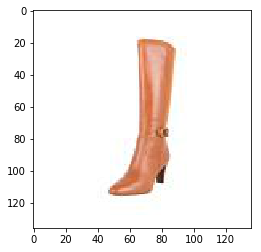

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(os.path.join(WORKING_DIR,"ut-zap50k-images-square","Boots",
                              "Knee High","Anne Klein","8059298.310.jpg"))
plt.imshow(img)

### Uploading the data to S3

We are going to transfer a subset of the Zappos50k dataset over to the default SageMaker bucket in your account. Training on the entire dataset will take hours on GPU as it involves training on a very large dataset of image pair combinations. The goal of this notebook is to demonstrate the process by training on a small subet of the images. 

All the images, processed inputs, and indexes for the entire dataset are publicly shared in the same S3 download location if you wish to experiment on the entire dataset. [Utility scripts](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/notebooks/pytorch_siamese_network_utils.ipynb) have also been made public for you to leverage if you wish to generate your own indexes and pre-processed dataset (npy tensors). 

This notebook works with a subset of sample images for the purpose of learning. The goal is to give you a sense of the experience involved in the training and inference process. You can easily modify the code in this notebook afterwards to work with a large set of the data if you wish.

In [22]:
import time
import pandas as pd

SAMPLE_TRAINING_IMG_PATHS = "sample_training_images.csv"
os.system("aws s3 cp {}/data/sample/{} {}"
          .format(DOWNLOAD_S3URI,SAMPLE_TRAINING_IMG_PATHS,WORKING_DIR))

df = pd.read_csv(os.path.join(WORKING_DIR,SAMPLE_TRAINING_IMG_PATHS), header=None, usecols=[0], names=['img'])
IMG_PATHS = df['img'].tolist()

start = time.time()

for paths in IMG_PATHS :
    esc_path = paths.replace(' ','\ ')
    os.system('aws s3 cp ' + (DOWNLOAD_S3URI+"/data/raw/"+esc_path) +
              ' '+ DATA_S3URI+'/'+esc_path +
              ' --recursive --quiet --source-region us-west-2 --region '+ AWS_REGION)

end = time.time()
print("Sync completed in "+ str(int(end - start))+" seconds")

Sync completed in 10 seconds


### PyTorch DataSet indexes

Now we copy over index files that have been generated for you. These indexes will be used by the training script to locate selected images during training.

The script expects indexes named as follows for the training and test sets respectively:
-  zappos50k-tuples-index-train.csv
-  zappos50k-tuples-index-test.csv

In [26]:
os.system("aws s3 cp {}/index/zappos50k-partial-tuples-index-test.csv {}/ --source-region us-west-2 --region {}"
         .format(DOWNLOAD_S3URI,DATA_S3URI,AWS_REGION))

os.system("aws s3 cp {}/index/zappos50k-partial-tuples-index-train.csv {}/ --source-region us-west-2 --region {}"
         .format(DOWNLOAD_S3URI,DATA_S3URI,AWS_REGION))

##renaming files for convenience
os.system("aws s3 mv {}/zappos50k-partial-tuples-index-train.csv {}/zappos50k-tuples-index-train.csv --quiet"
         .format(DATA_S3URI,DATA_S3URI))
os.system("aws s3 mv {}/zappos50k-partial-tuples-index-test.csv {}/zappos50k-tuples-index-test.csv --quiet"
         .format(DATA_S3URI,DATA_S3URI))

print("Copied zappos50k-tuples-index-train.csv and zappos50k-tuples-index-test.csv and to {}:"
      .format(DATA_S3URI))

Copied zappos50k-tuples-index-train.csv and zappos50k-tuples-index-test.csv and to s3://sagemaker-us-west-2-803235869972/sagemaker/shop-by-style/data:


### Pre-trained model artifacts

Next, we copy over the artifacts for a pre-trained version of the model that we'll be creating in the following steps. This pre-trained model has been trained on the entire data set with a training algorithm that is slightly different from the one used in this notebook to adapt to the larger training set. Reference the [public code here for details](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/src/similarity/siamese2.py). During the inference stages, we'll use the pre-trained model to obtain better results than the example model that you'll create for the purpose of learning the process.

In [27]:
MODELS_S3URI = "s3://"+os.path.join(SAGEMAKER_BUCKET,'sagemaker','shop-by-style','model','output')
SOURCE_S3URI = "s3://"+os.path.join(SAGEMAKER_BUCKET,'sagemaker','shop-by-style','model','source')
MODEL_VERSION = 6

In [32]:
start = time.time()
os.system('aws s3 sync {}/models/v{}/ {} --source-region us-west-2 --region {} --quiet'
         .format(DOWNLOAD_S3URI,MODEL_VERSION,MODELS_S3URI,AWS_REGION))
os.system('aws s3 cp {}/source/similarity/sourcedir.tar.gz {}/sourcedir.tar.gz --source-region us-west-2 --region {} --quiet'
         .format(DOWNLOAD_S3URI,SOURCE_S3URI,AWS_REGION))
end = time.time()

print("Sync completed in {} seconds.".format(end-start))
print("Location of pretrained model artifacts: {}/model.tar.gz".format(MODELS_S3URI))
print("Location of your pre-trained model source code: {}/sourcedir.tar.gz".format(SOURCE_S3URI))

Sync completed in 3.2846627235412598 seconds.
Location of pretrained model artifacts: s3://sagemaker-us-west-2-803235869972/sagemaker/shop-by-style/model/output/model.tar.gz
Location of your pre-trained model source code: s3://sagemaker-us-west-2-803235869972/sagemaker/shop-by-style/model/source/sourcedir.tar.gz


## Train

We need to provide a training script that can run on the SageMaker platform. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In the following steps, scripts are provided to build and train the following model:

### Deep Siamese Network Architecture

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/siamese_network_diag.jpg" width="65%" height="65%" align="left"/>

### Preview Results

Before we build and train our model, let's preview some example results from a trained model.

Download a subset of the Zappos50K dataset over to our Notebook instance along with some inference results generated from a pre-trained model.

In [33]:
import os

SAMPLES_S3URI = DOWNLOAD_S3URI+'/data/sample/'

SAMPLE_IMAGES_FILE = "zappos50k-sample-images.zip"
SAMPLE_IMAGES_S3URI = SAMPLES_S3URI+SAMPLE_IMAGES_FILE

OUTPUT_SAMPLES_FILE = "sample-v2-batch-out.zip"
OUTPUT_SAMPLES_S3URI = SAMPLES_S3URI+"batch-workshop/out/"+OUTPUT_SAMPLES_FILE

print('Downloading sample test images... \n')
os.system("aws s3 cp {} {} --source-region us-west-2 --region {}"
         .format(SAMPLE_IMAGES_S3URI,WORKING_DIR,AWS_REGION))
os.system("unzip ./"+SAMPLE_IMAGES_FILE)

sample_images_fp = os.path.join(WORKING_DIR,SAMPLE_IMAGES_FILE)
if os.path.isfile(sample_images_fp) :
    print("Samples test images were successfully downloaded to: "+sample_images_fp)
else :
    print("Failed to download sample test images \n")

print('\nDownloading sample inference results... \n')
os.system("aws s3 cp {} {} --source-region us-west-2 --region {}"
         .format(OUTPUT_SAMPLES_S3URI,WORKING_DIR,AWS_REGION))

os.system("unzip ./"+OUTPUT_SAMPLES_FILE)

sample_inferences_fp = os.path.join(WORKING_DIR,OUTPUT_SAMPLES_FILE)
if os.path.isfile(sample_inferences_fp) :
    print("Samples inference results were successfully downloaded to: "+sample_inferences_fp)
else :
    print("Failed to download sample inference results")


Samples test images were successfully downloaded to: /home/ec2-user/SageMaker/zappos50k-sample-images.zip


Samples inference results were successfully downloaded to: /home/ec2-user/SageMaker/sample-v2-batch-out.zip


Now let's load the sample outputs into Pandas dataframes...

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

LOCAL_OUTPUT_DIR = os.path.join(WORKING_DIR,'out')
LOCAL_DATA_DIR = os.path.join(WORKING_DIR,'data')
SAMPLE_PRODUCTS = []

def load_sample_outputs() :
    i = 0
    for (root, _, files) in os.walk(LOCAL_OUTPUT_DIR) :
        for f in files :
            fp = os.path.join(root,f)
            df = pd.read_csv(fp, header=None, names=['img','sim'])
            p=fp.replace(LOCAL_OUTPUT_DIR,'').replace('.csv','')
            print(str(i)+": "+p)
            SAMPLE_PRODUCTS.append({"n":p, "sim": df.sort_values(['sim'], ascending=True)})
            i = i+1

            import matplotlib.pyplot as plt
    
def display_similiar_products(product_info) :
    count = 0
    columns = 7
    BATCHES_TO_DISPLAY = 3

    fig = plt.figure(figsize=(columns*2, BATCHES_TO_DISPLAY*3))
    fig.subplots_adjust(wspace=.1)

    products = product_info['sim']
    print(product_info['n'])
    for (index, row) in products[0:columns*BATCHES_TO_DISPLAY].iterrows() :

        count += 1
        ax = fig.add_subplot(BATCHES_TO_DISPLAY, columns, count)   
        ax.set_title(round(row['sim'],5))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(plt.imread(os.path.join(LOCAL_DATA_DIR,row['img'])))
        
    plt.show()

load_sample_outputs()

0: /Boots/Knee High/Ariat/7992449.16158
1: /Boots/Knee High/Anne Klein/8032745.10224
2: /Boots/Over the Knee/Calvin Klein Collection/8005712.365488
3: /Shoes/Oxfords/Calvin Klein/7943176.325
4: /Shoes/Oxfords/Rockport/7996677.6194
5: /Shoes/Oxfords/Bass/7563706.3
6: /Sandals/Heel/Fly Flot/7418709.9


### Visualize Samples

The output from the cell above lists 7 products, which have pre-generated inferences. Run the cell below to view visually similar products. The first image is the product we're querying, and the products that follow are ordered by similarity (ordered from left to right and top to bottom in descending similarity). Change the index value from 0-6 if you like to preview other products.

The images displayed are in ascending order of similarity (left to right and top to bottom). The value above the images represent an unnormalized similarity score. The first image is the product we're using to query for other stylistically similar products. It's value isn't exactly zero due to floating-point precision and the fact that this model represents a generalized approximation.

/Shoes/Oxfords/Calvin Klein/7943176.325


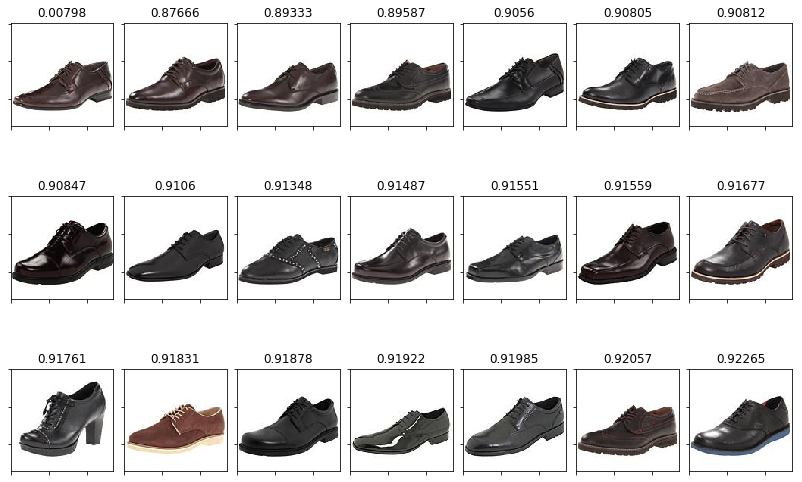

In [35]:
display_similiar_products(SAMPLE_PRODUCTS[3])

### Download the provided scripts

Let's move on to building and training a model. First, we download the scripts:

-  cnn.py: this script implements a siamese network in PyTorch. It uses a pre-trained ResNet model, and replaces the last layer with a dense layer with the number of dimensions as specified by class parameters. All layers except the last have been frozen for training.

-  siamese.py: contains all the training logic. The siamese network takes batches of image pairs, uses the CNN to extract salient features and vectorize the images, and minimizes a contrastive loss function according to the L1 distances between the image vectors and the provided labels.

-  requirements.txt: describes the dependencies that are required by the scripts that aren't pre-installed on the SageMaker PyTorch container. 

In [39]:
os.system("mkdir -p "+SOURCE_DIR)
os.system("aws s3 cp {}/{}/cnn.py ./{} --source-region us-west-2 --region {}"
         .format(DOWNLOAD_S3URI,SOURCE_DIR,SOURCE_DIR,AWS_REGION))
os.system("aws s3 cp {}/{}/siamese.py ./{} --source-region us-west-2 --region {}"
         .format(DOWNLOAD_S3URI,SOURCE_DIR,SOURCE_DIR,AWS_REGION))
os.system("aws s3 cp {}/{}/requirements.txt ./{} --source-region us-west-2 --region {}"
         .format(DOWNLOAD_S3URI,SOURCE_DIR,SOURCE_DIR,AWS_REGION))

print("Downloaded cnn.py, siamese.py, requirements.py to: {}/{}".format(os.getcwd(),SOURCE_DIR))

Downloaded cnn.py, siamese.py, requirements.py to: /home/ec2-user/SageMaker/source/similarity


### Model Script

Run the cell below if you like to view the script for the PyTorch model.

In [40]:
!pygmentize 'source/similarity/cnn.py'

import torch
import torch.nn as nn
import torchvision.models as models

class CNN(nn.Module):

    COSINE_SIMILARITY = 0
    L1_SIMILARITY = 1
    L2_SIMILARITY = 2
    PARAM_DISTANCE_DECAY_RATE = 0.5
    
    @staticmethod
    def exp_manhattan_distance(v1,v2) :

        d = torch.pow(nn.functional.pairwise_distance(v1,v2,1),CNN.PARAM_DISTANCE_DECAY_RATE)
        return 1.0 - torch.exp(-d)

    @staticmethod
    def exp_euclidian_distance(v1,v2) :
        d = torch.pow(nn.functional.pairwise_distance(v1,v2,2),CNN.PARAM_DISTANCE_DECAY_RATE)
        return 1.0 - torch.exp(-d)

    @staticmethod
    def inv_cosine_similarity(v1,v2) :
        return torch.abs(torch.abs(nn.functional.cosine_similarity(v1,v2)) - 1.0)

    sim_fns = [inv_cosine_similarity,  exp_manhattan_distance, exp_euclidian_distance]
    sim_fn = sim_fns[L1_SIMILARITY]
    
    def build_model(self, dims, v):
        
        if v == 18:
            cnn = models.resnet18(pretrained=True)
        elif v == 34:
           

### Training Script

Run the cell below if you like to view the script for training the siamese network on PyTorch. 

In [41]:
!pygmentize 'source/similarity/siamese.py'

import argparse
import os
import sys
import time
import copy
import math
import warnings
import csv
import logging

from PIL import Image
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

from cnn import CNN as cnn

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
    
parser = argparse.ArgumentParser(description='PyTorch CNN Siamese Network')

# Hyperparameters sent by the client are passed as command-line arguments to the script.
parser.add_argument('--batch-size', type=int, default=64, help='mini batch size')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='learning rate')
parser.add_argument('--similarity-dims', type=int, default=64, 
                    help='the number o

### Hyperparameters

Next we define the hyperparameters for our training job. The configurations are set to train on a single epoch. In practice, you'll train for a longer period to obtain better results. In this lab, our goal is to be familiarized with the process.

In [42]:
PARAM_EPOCHS = 1
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-6
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'
PARAM_BEST_MODEL_METRIC = 'test-loss'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER,
                    'best-model-metric' : PARAM_BEST_MODEL_METRIC
                }

### Define the PyTorch Estimator

The provided custom PyTorch training script can now be trained on SageMaker training servers without further setup. A PyTorch estimator needs to be instantiated as shown below specifying the training script to run, hyperparameters, and the infrastructure to use.

In [43]:
from sagemaker.pytorch import PyTorch

def default_training_instancetype(region) :
    
    inst_map = {
        'us-west-2': 'ml.p3.2xlarge',
        'us-east-2': 'ml.p3.2xlarge',
        'eu-west-1': 'ml.p3.2xlarge',
        'ap-southeast-2': 'ml.p2.xlarge',
        'ap-northeast-1': 'ml.p3.2xlarge'
    }
    
    try :
        
        default = inst_map[region]
        
    except :
        print("This notebook wasn't tested in the region you're running in! Switch regions, or modify the code at your own discretion.")
        
    return default
    
estimator = PyTorch(entry_point="siamese.py",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type=default_training_instancetype(AWS_REGION),
                    source_dir=SOURCE_DIR,
                    hyperparameters=HYPERPARAMETERS)

### Run the Estimator

The training job is started simply by calling fit() on the estimator, and specifying the location of our training data and indexes. Note that you could specify a different location for your test set, but this isn't necessary as the provided indexes are used to seperate the training and test sets within the provided data corpus.  

    If you train the model without changing the dataset subset or the default parameters provided, the training will complete in 10-20 minutes using a ml.p3.2xlarge.

In [44]:
estimator.fit({'train':DATA_S3URI})

2019-06-28 18:07:46 Starting - Starting the training job...
2019-06-28 18:07:51 Starting - Launching requested ML instances......
2019-06-28 18:08:57 Starting - Preparing the instances for training......
2019-06-28 18:10:12 Downloading - Downloading input data...
2019-06-28 18:10:33 Training - Downloading the training image..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-06-28 18:10:59,457 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-06-28 18:10:59,484 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-06-28 18:11:00,115 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-06-28 18:11:00,359 sagemaker-containers INFO     Module siamese does not provide a setup.py. 
Generating setup.py
2019-06-28 18:11:00,359 sagemaker-containers INFO     Generating setup.cfg
2019-06-28 18:11:00,359 sagemaker-container


2019-06-28 18:17:32 Uploading - Uploading generated training model
2019-06-28 18:18:23 Completed - Training job completed
Billable seconds: 492


## Real-time Inference

Once you have a trained model, you probably want to do some testing and evaluation on the model. Deploying a SageMaker model for real-time inference might be useful at this stage. Let's create an endpoint that takes two image tensors and returns the similarity measure between the images as a json output.

First, download the inference script, which will be used as the entry point for a real-time inference model.

In [49]:
os.system("mkdir -p ".format(SOURCE_DIR))

os.system("aws s3 cp {}/{}/inference.py ./{} --source-region us-west-2 --region {}"
          .format(DOWNLOAD_S3URI,SOURCE_DIR,SOURCE_DIR,AWS_REGION))

print("Downloaded model serving script, inference.py, to: {}/{}"
      .format(os.getcwd(),SOURCE_DIR))

Downloaded model serving script, inference.py, to: /home/ec2-user/SageMaker/source/similarity


Run the cell below if you like to view the real-time inference script.

In [50]:
!pygmentize 'source/similarity/inference.py'

import logging
import json
import os
import torch
import pickle
from cnn import CNN
import numpy as np
from io import BytesIO

OUTPUT_CONTENT_TYPE = 'application/json'
INPUT_CONTENT_TYPE = 'application/x-npy'
logger = logging.getLogger(__name__)

def model_fn(model_dir):
    
    model_info = {}
    
    with open(os.path.join(model_dir, 'model_info.pth'), 'rb') as f:
        model_info = torch.load(f)
    
    print('model_info: {}'.format(model_info))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    logger.info('Current device: {}'.format(device))
    model = CNN(similarity_dims=model_info['simililarity-dims'])

    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    
    model.eval()
    return model

def output_fn(prediction_output, accept=OUTPUT_CONTENT_TYPE):
    logger.info('Serializing the generated output.')
    if accept == OUTPUT_CONTENT_TYPE:
        return json.dumps(prediction_outpu

Run this cell to set a name for our real-time inference endpoint.

In [51]:
RT_ENDPOINT_NAME = "rt-zappos50k-siamese-cnn"

### Deploy Endpoint

Run the following code to register a model, and deploy our endpoint. Note that the configurations utilize the pre-trained model that was downloaded previously.

The model uses the inference.py script as it's entry point.

In [53]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer

rtModel = PyTorchModel(model_data=MODELS_S3URI+'/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

rtPredictor = rtModel.deploy(instance_type='ml.c5.xlarge', 
                                   initial_instance_count=1,
                                   endpoint_name=RT_ENDPOINT_NAME)
                      
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

---------------------------------------------------------------------------!

### Use an Existing Endpoint

During development you may go through a few training cycles. Typically you'll build and train the model locally, run a remote training job for larger scale training, and perhaps do some manual model evaluation with the help of a real-time endpoint. 

If you've already deployed an real-time endpoint previously, you can run the following code snippet instead of the prevous snippet to acquire a reference to the existing endpoint instead of deploying a new one.

In [54]:
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer
        
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

### Test the Endpoint

First, run the cell below to initialize some constants and utility functions

In [78]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])

def getSampleFileName(cat,subcat,brand,file):
    return os.path.join(cat,subcat,brand,file)

SAMPLE_IMG_LOCS = [getSampleFileName("Boots","Knee High","Anne Klein","8059298.310.jpg"),
                   getSampleFileName("Boots","Knee High","Anne Klein","8059298.310.jpg"),
                   getSampleFileName("Shoes","Oxfords","Bass","7563706.3.jpg"),
                   getSampleFileName("Shoes","Oxfords","Bass","7563706.3.jpg"),
                   getSampleFileName("Shoes","Oxfords","Bass","7563706.3.jpg"),
                   getSampleFileName("Shoes","Oxfords","Rockport","7996677.6194.jpg"),
                   getSampleFileName("Shoes","Oxfords","Calvin Klein","7943176.325.jpg"),
                   getSampleFileName("Boots","Over the Knee","Calvin Klein Collection","8005712.365488.jpg"),
                   getSampleFileName("Boots","Knee High","Anne Klein","8032745.10224.jpg"),
                   getSampleFileName("Boots","Knee High","Ariat","7992449.16158.jpg"),
                   getSampleFileName("Sandals","Heel","Fly Flot","7418709.9.jpg"),
                   getSampleFileName("Shoes","Oxfords","Bass","7563706.3.jpg")]

##Change the image by modifying the index into the SAMPLE_IMG_LOCS array
PRODUCT = SAMPLE_IMG_LOCS[9]

IMG1_LOC = os.path.join(WORKING_DIR,"data",PRODUCT)
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"

os.system("aws s3 cp {} {} --source-region us-west-2 --region {}"
          .format(os.path.join(DOWNLOAD_S3URI,"index",ZAPPOS50K_SAMPLE_INDEX),
                  os.path.join(WORKING_DIR,ZAPPOS50K_SAMPLE_INDEX),
                  AWS_REGION))
        
def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

Now let's run a quick test comparing an image with itself.

In [79]:
import numpy as np

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
imgPair= np.vstack((img1,img1))
res= rtPredictor.predict(imgPair)

print(res)

{'similarity': 0.00796806812286377}


Run the following snippet to display the similar products for our selection in order of most similar.

This is a real-time endpoint and the following code will make api calls a few hundred times comparing the selected product (image) to a few hundred others to capture similarity measures. It will take 5-6 minutes to execute. In practice, you can scale-out (optionally, with auto-scaling) to increase the throughput on the endpoint.

<i> Note that inference is being run on only a few hundred images veresus the 50K+ images in the full data set. </i>

In [80]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(LOCAL_DATA_DIR+'/'+r['img'], TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= rtPredictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)

pd.set_option("display.max_rows",10)
display(df)

,img,sim
22,Boots/Knee High/Ariat/7992449.16158.jpg,0.007968
4,Boots/Knee High/Anne Klein/8059298.310.jpg,0.867596
11,Boots/Knee High/Anne Klein/8032825.310.jpg,0.883828
9,Boots/Knee High/Anne Klein/8032743.310.jpg,0.891191
3,Boots/Knee High/Anne Klein/8032745.310.jpg,0.896389
...,...,...
172,Sandals/Heel/Onex/7622650.18.jpg,0.971113
173,Sandals/Heel/Onex/7622623.18.jpg,0.971791
174,Sandals/Heel/Onex/7622629.10881.jpg,0.973113
199,Shoes/Oxfords/Rockport/7996596.103.jpg,0.973807


### Visualize

Let's visualize the results from our sampling of a few hundred images. Note that you'll see better results if inference is ran on the entire product catalog of 50k+ images.

/home/ec2-user/SageMaker/data/Boots/Knee High/Ariat/7992449.16158.jpg


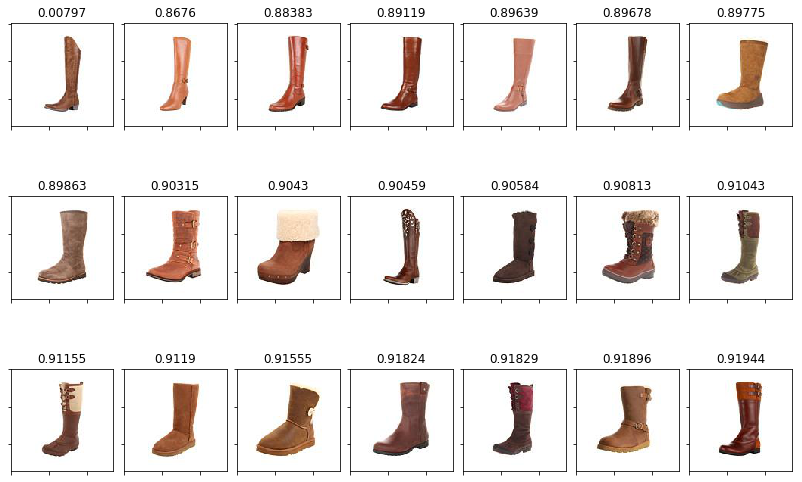

In [81]:
display_similiar_products({"n": IMG1_LOC, "sim": df})

## Automatic Model Tuning 

Hyperparameters can have substantial effect on the performance and outcome of your model training. A training process traditionally involves a strategy for exploring a range of hyperparameter values in search for a combination that delivers optimal results. 

SageMaker offers a capability call Automatic Model Tuning that performs the process of finding optimal hyperparameters for you by running training jobs in parallel for you and using a Bayesian search strategy to narrow down on the optimal combination of hyperparameters. Ultimately, this reduces the amount of training runs compared to basic hyperparameter search strategies like random search that most data scientists typically use to find optimal hyperparameters, and can lead to discovering parameters that lead to superior results.

The snippets below shows how to launch an hyperparameter tuning job programmatically. You are free to change the base hyperparameters and ranges if you wish. The settings below limit the parallel training jobs to one as it is configured to use GPU instances, and by default, AWS accounts only allow you to launch one of these instance types at a time. If your account has been approved for higher limits, and you are prepared to pay for the training time, you can change the parameters to launch multiple instances and jobs running in parallel to speed up the hyperparameter search process. The default sample datasets with the configurations below will require 40-60 minutes per training job, and run up to a maximum of 2 jobs. You can stop the tuning job from the console to end the process prematurely.

Run the cell below to initialize the base hyperparameters and estimator.

In [82]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

PARAM_EPOCHS = 8
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-4
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER
                }

tuned_estimator = PyTorch(entry_point="siamese.py",
                            role=role,
                            framework_version='0.4.0',
                            train_instance_count=1,
                            train_instance_type=default_training_instancetype(AWS_REGION),
                            source_dir=SOURCE_DIR,
                            base_job_name='HPO-pytorch',
                            hyperparameters=HYPERPARAMETERS)

### Define Hyperparameter Ranges

Hyperparameter tuning jobs are different from standard training jobs in the sense that you provide the job information about the range of hyperparameters you like to search. The snippet below demonstrates this idea. In this case, we'll explore multiple settings for the training learning rate, the number of dimensions configured in the last layer of the CNN as well as the type of optimizer to use (Adam vs. plain Stochastic Gradient Descent).

Lastly, an objective metric needs to be defined to determine what is the best model. The model that delivers the best results for the defined objective metric is what is ultimately delivered by the tuning job. The configurations below delivers the model and settings that result in the lowest "average training loss.' You are free to define whatever metric you like. For instance, in many cases, validation accuracy is likely what you're optimizing for.

This hyperparameter process runs up to 2 jobs sequentially. The time required to complete the HPO job will range from 3-6 hours depending on the instance type used. The instance type varies depending on the region you're running this lab in. In practice, you will also run more than 2 jobs, and to speed up the process, you will run multiple jobs in parallel. Running more parallel jobs will require contacting AWs Support to increasing the default soft limit for SageMaker p-family instances on your account. 

In [83]:
from sagemaker.tuner import HyperparameterTuner

HYPERPARAM_RANGES = {
                        'learning-rate': ContinuousParameter(1e-6, 1e-4),
                        'similarity-dims': CategoricalParameter([16,32,64,96,128]),
                        'optimizer': CategoricalParameter(['Adam','SGD'])
                    }

OBJECTIVE_METRIC_NAME = 'average training loss'
METRIC_DEFINITIONS = [{'Name': 'average training loss',
                       'Regex': 'Training set: Average loss: ([0-9\\.]+)'}]

# Configure HyperparameterTuner
tuner = HyperparameterTuner(estimator=tuned_estimator,
                            objective_metric_name = OBJECTIVE_METRIC_NAME,
                            hyperparameter_ranges  = HYPERPARAM_RANGES,
                            metric_definitions = METRIC_DEFINITIONS,
                            max_jobs=2,
                            max_parallel_jobs=1)

# Start hyperparameter tuning job
tuner.fit({'train': DATA_S3URI})

**[OPTIONAL]** Tuning jobs run asynchronously by default. You run the following cell to wait on the hyperparameter tuning job. Otherwise, you can continue on with the rest of the notebook. However, be aware that the following cells, which deploys your tuned model, won't run until the tuning job has complete. 

In [ ]:
tuner.wait()

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Deploy the Model

You can deploy the best model returned by the tuning job programatically in the same way you would deploy a model produced by a basic training job.

In this case, the model is deployed as a real-time endpoint. Note that the HPO tuning job is deployed asynchronously. The code snippets that follow can't be run until the tuner job ends.

In [91]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer

TUNED_MODEL_DATA = "s3://"+os.path.join(SAGEMAKER_BUCKET,tuner.best_training_job(),"output","model.tar.gz")

RT_TUNED_ENDPOINT_NAME = 'HPO-rt-zappos50k'

tuned_model = PyTorchModel(model_data=TUNED_MODEL_DATA, 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

tuned_predictor = tuned_model.deploy(instance_type='ml.c5.xlarge', 
                                   initial_instance_count=1,
                                   endpoint_name=RT_TUNED_ENDPOINT_NAME)
                      
tuned_predictor = RealTimePredictor(endpoint=RT_TUNED_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

--------------------------------------------------------------------------------------!

### Test the Model

Below are some constants and utilities for testing this model. You can change the value of PRODUCT if you like to visualize the similar products for something different from what is set below.

<i> Note that these constants, and utilities were defined previously. They're added here for redundancy in case some users skipped the previous section that deployed a real-time inference endpoint. </i>

In [92]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])

PRODUCT = os.path.join("Shoes","Oxfords","Bass","7563706.3.jpg")

IMG1_LOC = os.path.join(WORKING_DIR,"data",PRODUCT)
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"

os.system("aws s3 cp {} {} --source-region us-west-2 --region {}"
        .format(os.path.join(DOWNLOAD_S3URI,'index',ZAPPOS50K_SAMPLE_INDEX),
                os.path.join(WORKING_DIR,ZAPPOS50K_SAMPLE_INDEX),
                AWS_REGION))

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

### Display the results

Run the following snippet to display the similar products for our selection in order of most similar.

This is a real-time endpoint and the following code will make api calls a few hundred times comparing the selected product (image) to a few hundred others to capture similarity measures. It will take 5-6 minutes to execute.

In [94]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(os.path.join(LOCAL_DATA_DIR,r['img']), TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= tuned_predictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)

pd.set_option("display.max_rows",10)
display(df)

,img,sim
297,Shoes/Oxfords/Bass/7563706.3.jpg,0.005641
299,Shoes/Oxfords/Bass/7554499.72.jpg,0.848391
182,Shoes/Oxfords/Calvin Klein/7443617.2560.jpg,0.852126
243,Shoes/Oxfords/Rockport/7996724.3.jpg,0.854147
176,Shoes/Oxfords/Calvin Klein/7943176.3.jpg,0.858213
...,...,...
277,Shoes/Oxfords/Bass/7976075.9041.jpg,0.963508
164,Sandals/Heel/Onex/7313933.2044.jpg,0.967729
160,Sandals/Heel/Fly Flot/7418709.585.jpg,0.975828
302,Shoes/Oxfords/Bass/7976075.86183.jpg,0.980418


### Visualize

Let's visualize the results.

* Note that the tuned results probably won't be as good as the provided pre-trained model. The pre-trained model has been trained on the entire Zappos50K data set and on days worth of training time. The training on this lab is only on a subset of the data set. It also uses a [slightly different training algorithm than the one in the lab](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/src/similarity/siamese2.py). 

/home/ec2-user/SageMaker/data/Shoes/Oxfords/Bass/7563706.3.jpg


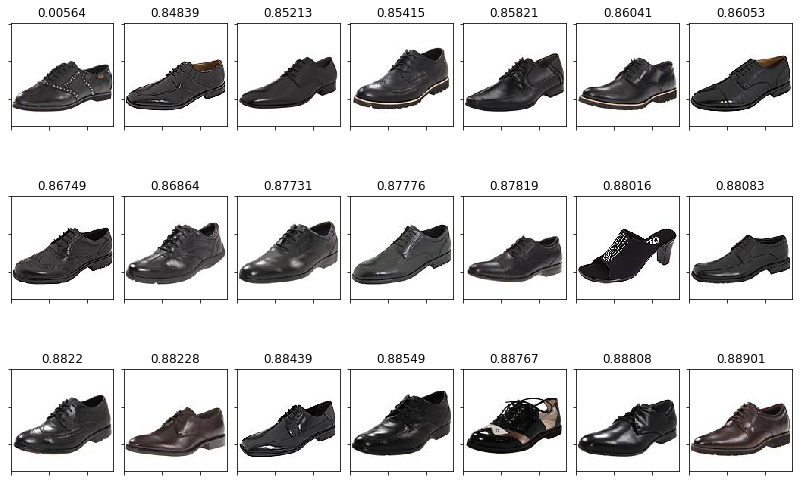

In [95]:
display_similiar_products({"n": IMG1_LOC, "sim": df})

## Programmatic Batch Inference

Similar to other SageMaker features, you have the option to launch a batch inference job from the console, or programatically as demonstrated in the cells below.

Once we have an optimized model, we're ready to run a large scale inference job to obtain similarity scores across our entire data set. This is most efficiently done as a batch inference job.

Run the cell below to download the script for batch inference.

In [96]:
os.system("mkdir -p "+SOURCE_DIR)
os.system("aws s3 cp {} {}"
          .format(os.path.join(DOWNLOAD_S3URI,SOURCE_DIR,"batch.py"),SOURCE_DIR))

0

Run the cell below if you like to view the batch inference script.

In [97]:
!pygmentize 'source/similarity/batch.py'

import logging
import json
import os
import torch
import pickle
from cnn import CNN
import numpy as np
import gzip
from io import BytesIO, StringIO

OUTPUT_CONTENT_TYPE = 'text/csv'
INPUT_CONTENT_TYPE = 'application/x-npy'
logger = logging.getLogger(__name__)

image_names = []

def model_fn(model_dir):
    
    model_info = {}
    
    with open(os.path.join(model_dir, 'model_info.pth'), 'rb') as f:
        model_info = torch.load(f)
    
    print('model_info: {}'.format(model_info))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    logger.info('Current device: {}'.format(device))
    model = CNN(similarity_dims=model_info['simililarity-dims'])

    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    
    model.eval()
    logger.info(model)
    return model


def input_fn(request_body, accept=INPUT_CONTENT_TYPE):
    logger.info('Deserializing the generated input.')
    if accept == INPUT_CONTENT

Set some constants

In [98]:
BATCH_INPUT_S3URI = os.path.join(DATA_S3URI,"batch","in")
BATCH_OUTPUT_S3URI = os.path.join(DATA_S3URI,"batch","out")
BATCH_MODEL_NAME = "batch-zappos50k-siamese-cnn"
BATCH_INSTANCE_TYPE = 'ml.c5.xlarge'

The batch inference job that we're going to create expects inputs in NPY format. The images have been pre-processed by packing pairs of image tensors in NPY format into gzip files, so that images can be sent to a SageMaker Batch Transform job cluster in batches. 

Pre-processed images have been provided for you. Run the cell to download them to your SageMaker bucket, so that your batch inference job has access to the input data.

As before, this notebook is running the job on a small subset of the full dataset for the sake of demonstration. You always have the option to reconfigure, and pre-process your own dataset to build a full-scale model.

In [99]:
start = time.time()
os.system("aws s3 sync {} {} --quiet --source-region us-west-2 --region {}"
          .format(os.path.join(DOWNLOAD_S3URI,"data","sample","batch-workshop","in"),
                  BATCH_INPUT_S3URI,
                  AWS_REGION))
end = time.time()

print("Sync completed in {} seconds.".format(end-start))

Sync completed in 2.427386999130249 seconds.


### Register a Model for Batch Inference

We need to register a model with SageMaker for the batch inference job. This model uses the batch inference script as the entry point. We'll use the pre-trained model that was downloaded in the previous steps.

In [100]:
from sagemaker.pytorch import PyTorchModel

batchModel = PyTorchModel(model_data=os.path.join(MODELS_S3URI,'model.tar.gz'), 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='batch.py',
                            source_dir=SOURCE_DIR)

batchModel.sagemaker_session = sagemaker_session
container_def = batchModel.prepare_container_def(instance_type=BATCH_INSTANCE_TYPE)
sagemaker_session.create_model(BATCH_MODEL_NAME, role, container_def)

Using already existing model: batch-zappos50k-siamese-cnn


'batch-zappos50k-siamese-cnn'

### Launch the Batch Inference Job

Now we're ready to run a Batch Inference job. Run the snippet below to launch a batch inference job programmatically.

In [101]:
from sagemaker.transformer import Transformer

transformer = Transformer(model_name=BATCH_MODEL_NAME,
                          instance_count=1,
                          instance_type= BATCH_INSTANCE_TYPE,
                          accept = 'text/csv',
                          output_path=BATCH_OUTPUT_S3URI
                         )
transformer.transform(BATCH_INPUT_S3URI, content_type= 'application/x-npy')

**[OPTIONAL]** Transformer jobs run asynchronously by default. You run the following cell to wait on the job. Otherwise, you can continue on with the rest of the notebook.

In [ ]:
transformer.wait()

## Experimental Ideas

The following sections demonstrate a technique inspired by Neural Style Transfer, which was first described in this [research paper](https://arxiv.org/pdf/1508.06576.pdf]). You may have seen neural style transfer techniques used in artistic applications. For instance, you could capture the style of Van Gogh's Starry Night, and apply it to a photograph to make it appear like a Van Gogh painting.

The diagram below illustrates the concept. "Style" is extracted at selected layers using gram matrices. The same is done for "content." The similarity between two products is measured by the weighted difference between the "style" and "content" elements of the image--in this case, footwear. 



<img src="https://reinvent2018-sagemaker-pytorch.s3-us-west-2.amazonaws.com/web/neural-style-similarity-arch-diag.jpg" width="100%" height="100%" align="left"/>



*Note: unlike the previous parts of the notebook, I've only provided rudimentary prototype code that is designed to run locally on the notebook. A production implementation could be in the form of a script for a clustering algorithm, or batch inference. If you choose to run the cells below, I recommend using a notebook with the same or more computational power as a ml.p3.2xlarge*

---

### Download Dataset

We'll need to prepare your notebook before you can run the prototype scripts. Run the commands below to copy the entire Zappos50K dataset over to your notebook.

In [136]:
start = time.time()
os.system("aws s3 cp {} {} --quiet"
          .format(os.path.join(DOWNLOAD_S3URI,'sample-gram-matrices-style-measurements.zip'),
                  os.path.join(WORKING_DIR,'sample-gram-matrices-style-measurements.zip')))
os.system("unzip -qo {}"
          .format(os.path.join(WORKING_DIR,
                               'sample-gram-matrices-style-measurements.zip')))

os.system("aws s3 cp {} {} --quiet"
              .format(os.path.join(DOWNLOAD_S3URI,'ut-zap50k-images-square.zip'),
                      os.path.join(WORKING_DIR,'ut-zap50k-images-square.zip')))

os.system("unzip -qo {}"
        .format(os.path.join(WORKING_DIR,'ut-zap50k-images-square.zip')))

os.system("aws s3 cp {} {} --quiet"
          .format(os.path.join(DOWNLOAD_S3URI,"index","zappos50k-index.csv"),
                  WORKING_DIR))

end = time.time()

print("Copy completed in {} seconds.".format(end-start))

Copy completed in 7.651947021484375 seconds.


If you want to run the algorithm yourself on different products, run the cells below. First we need to initialize the utility functions below.

In [131]:
from torchvision import transforms
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader

ZAPPOS50K_INDEX = os.path.join(WORKING_DIR, 'zappos50k-index.csv')

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

class Zappos50kDataset(Dataset):
   
    def __init__(self, csv_file, root_dir, transform=None):
        self.index = pd.read_csv(csv_file, header=None, usecols = [0,1])
        self.root_dir = root_dir
        self.transform = transform
  
    def __len__(self):
        return self.index.shape[0]

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.index.iloc[idx, 0])
        image = Image.open(img_name)
        image_tensor = self.transform(image)
        
        return {'name': self.index.iloc[idx, 0], 'tensor': image_tensor}

This utility function will be used for visualization

In [132]:
import matplotlib.pyplot as plt
DATA_DIR = os.path.join(WORKING_DIR,'ut-zap50k-images-square')
def display_similiar_products(products) :
    count = 0
    columns = 7
    BATCHES_TO_DISPLAY = 3

    fig = plt.figure(figsize=(columns*2, BATCHES_TO_DISPLAY*3))
    fig.subplots_adjust(wspace=.1)

    for (index, row) in products[0:columns*BATCHES_TO_DISPLAY].iterrows() :

        count += 1
        ax = fig.add_subplot(BATCHES_TO_DISPLAY, columns, count)   
        ax.set_title(round(row['sim'],5))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(plt.imread(os.path.join(DATA_DIR,row['img'])))
        
    plt.show()

### Baseline Results

Let's start with baselining results by measuring L1, L2 or cosine similarity using pre-trained CNNs. The script is defaulted to use VGG16 for simplicity, but ResNet-34 is also a good model to test.

Here are a few sample results from measuring L1 distance between image vectors generated by PyTorch's pre-trained VGG16 model. 

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/vgg16-l1-samples.jpg" width="100%" height="100%" align="left"/>

As illustrated by the sample results above, there are certain searches that are easy. We focus on a difficult example by searching for products that are stylistically similar to **Slippers/Slipper Flats/Baffin Kids/8054021.19667.jpg**

This product has a unique appearance, so there are few products that are stylistically similar.

In [133]:
import torchvision.models as models

## here are a few functions for calculating similarity. You should use L1 or L2. L1 is set by default
COSINE_SIMILARITY = 0
L1_DISTANCE = 1
L2_DISTANCE = 2
    
def manhattan_distance(v1,v2) :
    return nn.functional.pairwise_distance(v1,v2,1)

def euclidian_distance(v1,v2) :
    return nn.functional.pairwise_distance(v1,v2,2)

def cosine_similarity(v1,v2) :
    return nn.functional.cosine_similarity(v1,v2)

sim_fns = [cosine_similarity,  manhattan_distance, euclidian_distance]

def calc_dist(v1, v2, mode=L1_DISTANCE):
    return sim_fns[mode](v1,v2)

## wrapper function for a CNN model used for base lining.
def deep_image_classification_model_no_hooks() :

    cnn = models.vgg16(pretrained=True)
    #cnn = models.resnet34(pretrained=True)
    return cnn

Run the cell below to calculate similarity scores between the "SEARCH_IMG" and the rest of the Zappos50k dataset.

In [137]:
import torch
import torch.nn as nn

def getSampleFileName(cat,subcat,brand,file):
    return os.path.join(cat,subcat,brand,file)

SAMPLE_IMG_FILES = [
    getSampleFileName("Slippers","Slipper Flats","Baffin Kids","8054021.19667.jpg"),
    getSampleFileName("Sandals","Flat","Elephantito","7900238.764.jpg"),
    getSampleFileName("Shoes","Oxfords","Calvin Klein","7943176.3.jpg")]

SEARCH_IMG = SAMPLE_IMG_FILES[0]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = os.path.join(WORKING_DIR,'ut-zap50k-images-square')
PARAM_BATCH_SIZE = 16

print('Comparing image ['+SEARCH_IMG+'] with entire Zappos50K data set...')

model = deep_image_classification_model_no_hooks()
model = model.to(DEVICE)
model.eval() 

img = getImageTensor(os.path.join(WORKING_DIR,'ut-zap50k-images-square',SEARCH_IMG)
                     ,TRANSFORMATIONS)
img.unsqueeze_(0)  
img = img.to(DEVICE)

v1= model.forward(img)
        
zapposDS = Zappos50kDataset(ZAPPOS50K_INDEX, DATA_DIR, TRANSFORMATIONS)
zapposDL = torch.utils.data.DataLoader(dataset=zapposDS, batch_size= PARAM_BATCH_SIZE, shuffle=False)

results = None

for data in zapposDL:

    names = data.get('name')
    images = data.get('tensor').to(DEVICE)

    v2 = model.forward(images)
    #distances = calc_dist(v1,v2, mode=L1_DISTANCE)
    distances = calc_dist(v1,v2, mode=L2_DISTANCE)
    distances= distances.cpu().detach().numpy()

    df1= pd.DataFrame(names, columns=['img'])
    df2= pd.DataFrame(distances, columns=['sim'])
    df= df1.merge(df2, left_index=True,right_index=True)
    
    if results is not None :
        results=results.append(df, ignore_index=True)
    else :
        results = df

results = results.sort_values(by=['sim'])
display(results.head(30))

Comparing image [Slippers/Slipper Flats/Baffin Kids/8054021.19667.jpg] with entire Zappos50K data set...


,img,sim
43519,Slippers/Slipper Flats/Baffin Kids/8054021.196...,0.000125
43038,Slippers/Boot/Baffin/7486138.359.jpg,37.685703
48552,Sandals/Flat/Merrell/7875409.4774.jpg,38.267521
23679,Shoes/Firstwalker/Agatha Ruiz De La Prada Kids...,38.550968
24733,Shoes/Heels/Gentle Souls/7835020.21134.jpg,39.323700
...,...,...
33048,Boots/Ankle/The North Face Kids/7969264.352466...,41.009739
48572,Sandals/Flat/Merrell/7879753.9.jpg,41.069454
22692,Shoes/Oxfords/Rockport/7996596.103.jpg,41.140194
2290,Shoes/Sneakers and Athletic Shoes/etnies Kids/...,41.166233


Let's visualize the results

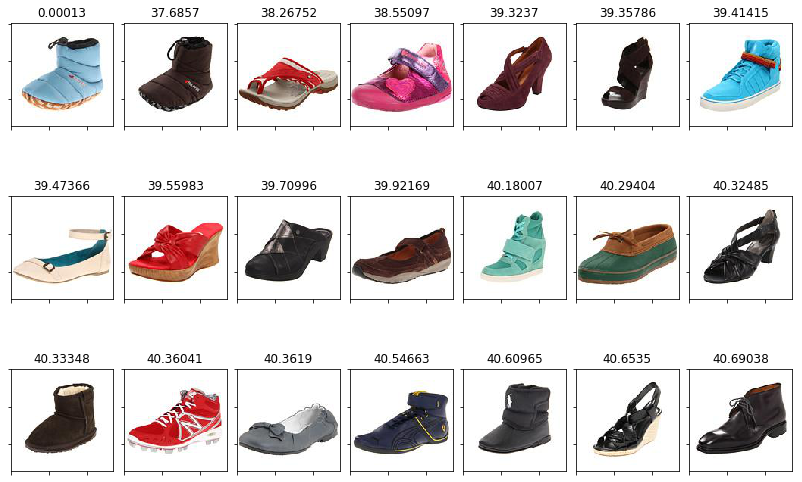

In [138]:
## Note that the script was defaulted to display results using L2 distance
display_similiar_products(results)

### Neural Style Inference

Now let's try the Neural Style Inference. Below are some sample results to demonstrate the effect of various configurations.

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/vgg16-style-transfer-simple-examples.jpg" width="100%" height="100%" align="left"/>




We can achieve more compelling results from the VGG16 model with the following configurations:
- Extract style from layers 1,11,29 and weight down the influence of layer 11 by 50%.
- Extract content from the final layer.
- Weight the influence of style and content measures by a ratio of 60:40.

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/vgg16-refined-configurations.jpg" width="50%" height="50%" align="left"/>

Below are is a model configured to replicate the results above. Hooks are injected into the pretrained VGG16 model to extra intermediary results. 

In [139]:
##for vgg16 tests
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np

COSINE_SIMILARITY = 0
L1_DISTANCE = 1
L2_DISTANCE = 2

style_layers = [1,11,29]
style_layer_weightings = [1,0.5,1]
content_layers = [29]
content_layer_weightings = [1]
beta = 0.6

def deep_image_classification_model() :

    cnn = models.vgg16(pretrained=True)
    
    for l in style_layers :
        cnn.features[l].register_forward_hook(style_hook)
    
    for l in content_layers :
        cnn.features[l].register_forward_hook(content_hook)
        
    return cnn

def calc_gram_matrices(activations):
  
    gms = []
    for a in activations :
        
        b, c, h, w = a.size()
        
        features = a.view(b, c, h*w)
        ft = torch.transpose(features, 1,2)
        G = torch.bmm(features, ft)
        g= G.view(b,c,c)
        gms.append(G)
        
    return gms

def content_hook(module, input, output):
    content_outputs.append(output)
    
def style_hook(module, input, output):
    style_outputs.append(output)
    
def avg_gram_distance(gms1,gms2,outputs) :
        
    style_diff = 0
    for i in range(len(outputs)) :

        denom=(2*outputs[i].shape[1]*outputs[i].shape[2]*outputs[i].shape[3])**2
        style_diff+= style_layer_weightings[i]*(torch.sum(torch.pow(gms1[i] - gms2[i],2),dim=[1,2])/denom)

    style_diff = (1-(style_diff/len(outputs)))
    
    return style_diff
    
def avg_content_distance(target_activations, compare_activations):
    
    content_diff = 0
 
    for i in range(len(compare_activations)) :
  
        denom=(2*compare_activations[i].shape[1]*compare_activations[i].shape[2]*compare_activations[i].shape[3])
        content_diff+= content_layer_weightings[i]*torch.sum(torch.pow(compare_activations[i] - target_activations[i],2),dim=[1,2,3])/denom
            
    content_diff = (1 - (content_diff/len(compare_activations)))
 
    return content_diff    

You can now run the script below to resplicate the results. This script hasn't been optimized, and will take over 15 minutes to run. It calculates stylistically similarity between our selected product, and the rest of the Zappos50k dataset.

In [140]:
SEARCH_IMG=os.path.join("Slippers","Slipper Flats","Baffin Kids","8054021.19667.jpg")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = os.path.join(WORKING_DIR,'ut-zap50k-images-square')
PARAM_BATCH_SIZE = 16

print('Comparing image ['+SEARCH_IMG+'] with entire Zappos50K data set...')

style_outputs= []
content_outputs = []
model = deep_image_classification_model()
model = model.to(DEVICE)
model.eval() 

img = getImageTensor(os.path.join(WORKING_DIR,'ut-zap50k-images-square',SEARCH_IMG),
                     TRANSFORMATIONS)
img.unsqueeze_(0)  
img = img.to(DEVICE)

v1= model.forward(img)
target_activations_style = style_outputs
target_activations_content = content_outputs

target_gms = calc_gram_matrices(target_activations_style)
        
zapposDS = Zappos50kDataset(ZAPPOS50K_INDEX, DATA_DIR, TRANSFORMATIONS)
zapposDL = torch.utils.data.DataLoader(dataset=zapposDS, batch_size= PARAM_BATCH_SIZE, shuffle=False)

results = None

for data in zapposDL:

    names = data.get('name')
    images = data.get('tensor').to(DEVICE)

    style_outputs= []
    content_outputs= []
    v2 = model.forward(images)
    compare_gms = calc_gram_matrices(style_outputs)
    style_measure = avg_gram_distance(target_gms,compare_gms,style_outputs)
    
    content_measure = avg_content_distance(target_activations_content,content_outputs)
    
    style_measure= style_measure.cpu().detach().numpy()
    content_measure = content_measure.cpu().detach().numpy()
    
    sim_measure = ((1-beta)*content_measure) + (beta*style_measure)

    df1= pd.DataFrame(names, columns=['img'])
    df2= pd.DataFrame(sim_measure, columns=['sim'])
    df= df1.merge(df2, left_index=True,right_index=True)
    
    if results is not None :
        results=results.append(df, ignore_index=True)
    else :
        results = df

results = results = results.sort_values(by=['sim'], ascending=False)
display(results.head(30))

Comparing image [Slippers/Slipper Flats/Baffin Kids/8054021.19667.jpg] with entire Zappos50K data set...


,img,sim
43519,Slippers/Slipper Flats/Baffin Kids/8054021.196...,1.000000
43038,Slippers/Boot/Baffin/7486138.359.jpg,0.933267
43522,Slippers/Slipper Flats/Baffin Kids/8054021.3.jpg,0.930590
43518,Slippers/Slipper Flats/Baffin Kids/8054021.189...,0.927584
31867,Boots/Ankle/Baffin/7577482.19667.jpg,0.926239
...,...,...
33485,Boots/Ankle/Sperry Top-Sider/7569458.366132.jpg,0.920989
20020,Shoes/Clogs and Mules/Fly Flot/7874180.158.jpg,0.920951
43904,Slippers/Slipper Flats/Irish Setter/7823636.43...,0.920872
11327,Shoes/Sneakers and Athletic Shoes/Vibram FiveF...,0.920702


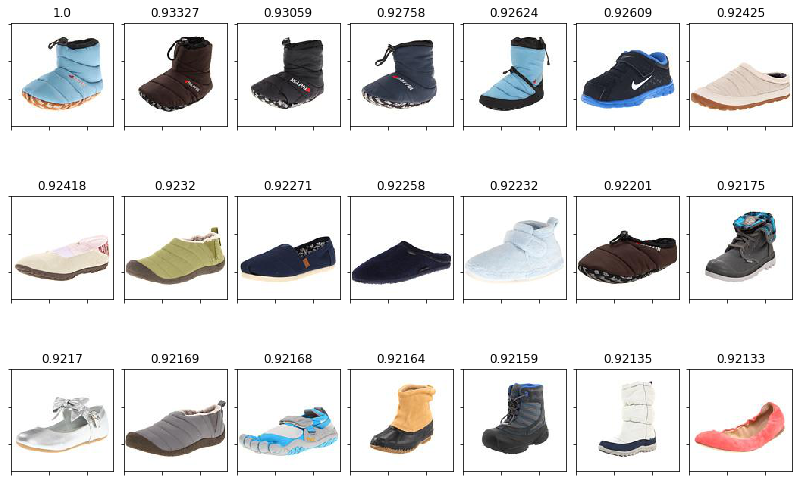

In [141]:
display_similiar_products(results)

You can also experiment results with other models. Resnet is harder to work with, but yields better results. Resnet-34 has the benefit of being a light-weight model making it potentially an ideal model for inference on a light-weight device running at the edge.

Below are baseline results for ResNet-34 for both L1 and L2 distance as similarity measures.

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/resnet-34-l1-l2-distance.jpg" width="80%" height="80%" align="left"/>

Much better results can be achieved using Neural Style inference with the following configurations:

- Weight style and content with a 50:50 ratio

Use the following layers for styling:
- Second convolutional layer of first Resnet block, weighting 100%
- Second convolutional layer of third Resnet block, weighted down to 30% 

Use the following for content layers:
- First convolutional layer of fifth Resnet block, weighting 100%

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/resnet-34-refined-results.jpg" width="50%" height="50%" align="left"/>

Run this script to configure the model as described above.

In [142]:
##for resnet-34 tests
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np

COSINE_SIMILARITY = 0
L1_DISTANCE = 1
L2_DISTANCE = 2

style_layers = [1,11,29]
style_layer_weightings = [1,0.3,0]
content_layers = [29]
content_layer_weightings = [1]
beta = 0.5

def deep_image_classification_model() :

    cnn = models.resnet34(pretrained=True)
    cnn.layer1[0].bn2.register_forward_hook(style_hook)
    cnn.layer2[2].bn2.register_forward_hook(style_hook)    
    cnn.layer4[1].bn2.register_forward_hook(content_hook)
    
    return cnn

Now let's run the script again to measure stylistic similarity for our selected product, and the rest of the Zappos50k dataset using Neural Style Inference.

In [143]:
SEARCH_IMG=os.path.join("Slippers","Slipper Flats","Baffin Kids","8054021.19667.jpg")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = os.path.join(WORKING_DIR,'ut-zap50k-images-square')
PARAM_BATCH_SIZE = 16

print('Comparing image ['+SEARCH_IMG+'] with entire Zappos50K data set...')

style_outputs= []
content_outputs = []
model = deep_image_classification_model()
model = model.to(DEVICE)
model.eval() 

img = getImageTensor(os.path.join(WORKING_DIR,'ut-zap50k-images-square',SEARCH_IMG),TRANSFORMATIONS)
img.unsqueeze_(0)  
img = img.to(DEVICE)

v1= model.forward(img)
target_activations_style = style_outputs
target_activations_content = content_outputs

target_gms = calc_gram_matrices(target_activations_style)
        
zapposDS = Zappos50kDataset(ZAPPOS50K_INDEX, DATA_DIR, TRANSFORMATIONS)
zapposDL = torch.utils.data.DataLoader(dataset=zapposDS, batch_size= PARAM_BATCH_SIZE, shuffle=False)

results = None

for data in zapposDL:

    names = data.get('name')
    images = data.get('tensor').to(DEVICE)

    style_outputs= []
    content_outputs= []
    v2 = model.forward(images)
    compare_gms = calc_gram_matrices(style_outputs)
    style_measure = avg_gram_distance(target_gms,compare_gms,style_outputs)
    
    content_measure = avg_content_distance(target_activations_content,content_outputs)
    
    style_measure= style_measure.cpu().detach().numpy()
    content_measure = content_measure.cpu().detach().numpy()
    
    sim_measure = ((1-beta)*content_measure) + (beta*style_measure)

    df1= pd.DataFrame(names, columns=['img'])
    df2= pd.DataFrame(sim_measure, columns=['sim'])
    df= df1.merge(df2, left_index=True,right_index=True)
    
    if results is not None :
        results=results.append(df, ignore_index=True)
    else :
        results = df

results = results = results.sort_values(by=['sim'], ascending=False)
display(results.head(30))

Comparing image [Slippers/Slipper Flats/Baffin Kids/8054021.19667.jpg] with entire Zappos50K data set...


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 44913641.24it/s]


,img,sim
43519,Slippers/Slipper Flats/Baffin Kids/8054021.196...,1.000000
43518,Slippers/Slipper Flats/Baffin Kids/8054021.189...,0.919720
43038,Slippers/Boot/Baffin/7486138.359.jpg,0.918952
43036,Slippers/Boot/Baffin/7486138.9.jpg,0.914850
43037,Slippers/Boot/Baffin/7486138.135957.jpg,0.908311
...,...,...
31620,Boots/Ankle/SKECHERS/8020099.3098.jpg,0.896636
35955,Boots/Ankle/Primigi Kids/8031907.6.jpg,0.896377
23625,Shoes/Firstwalker/Kid Express/7399332.494.jpg,0.896313
39161,Boots/Mid-Calf/Khombu/8003689.3.jpg,0.896284


In [ ]:
display_similiar_products(results)